In [3]:
import tensorflow as tf
import os


In [4]:
# Image size and batch size
image_size = (380, 380)
batch_size = 64

### Load the folder and label

In [ ]:
# The main folder
base_path = r"C:\Users\mukun\Desktop\BE Project\ai-generated-image-detect-EfficientNetB4\Dataset\train"

# Create list of file paths and corresponding labels
file_paths = []
labels = []

# Iterate through 'fake' and 'real' subfolders to collect file paths and labels
for label, category in enumerate(['fake', 'real']):
    category_path = os.path.join(base_path, category)
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        file_paths.append(file_path)
        labels.append(label)  # Assign label 0 for 'fake' and 1 for 'real'

In [6]:
import pandas as pd

# Check class distribution
class_distribution = pd.Series(labels).value_counts()
print("Class Distribution:")
print(class_distribution)

# Calculate class percentages
total_samples = len(labels)
class_percentages = class_distribution / total_samples
print("\nClass Percentages:")
print(class_percentages)


Class Distribution:
0    3780
1    3780
Name: count, dtype: int64

Class Percentages:
0    0.5
1    0.5
Name: count, dtype: float64


In [7]:
import cv2
# Check the dimension of the data
def get_image_dimensions(file_path):
    img = cv2.imread(file_path)

    if img is not None:
        # Get image dimensions (height, width, channels)
        height, width, channels = img.shape
        return height, width, channels
    else:
        print(f"Error: Failed to load image at {file_path}")
        return None

# Display dimensions of the first 5 images
num_images_to_display = 5

if len(file_paths) >= num_images_to_display:
    print(f"Displaying dimensions of the first {num_images_to_display} images:")

    for i in range(num_images_to_display):
        image_path = file_paths[i]
        dimensions = get_image_dimensions(image_path)

        if dimensions is not None:
            height, width, channels = dimensions
            print(f"Image {i+1}:")
            print(f"  Height: {height} pixels")
            print(f"  Width: {width} pixels")
            print(f"  Channels (depth): {channels}")
        else:
            print(f"Image {i+1}: Error loading image dimensions")
else:
    print("No image files found")

Displaying dimensions of the first 5 images:
Image 1:
  Height: 1024 pixels
  Width: 1024 pixels
  Channels (depth): 3
Image 2:
  Height: 928 pixels
  Width: 1232 pixels
  Channels (depth): 3
Image 3:
  Height: 1200 pixels
  Width: 960 pixels
  Channels (depth): 3
Image 4:
  Height: 1152 pixels
  Width: 832 pixels
  Channels (depth): 3
Image 5:
  Height: 1152 pixels
  Width: 1664 pixels
  Channels (depth): 3


### Visualization with labels

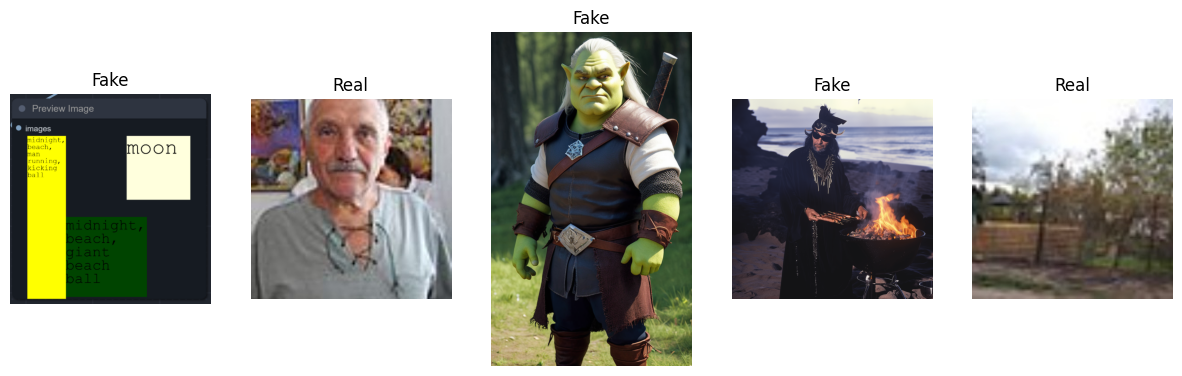

In [8]:
import matplotlib.pyplot as plt
import random

num_images_to_display = 5

if len(file_paths) >= num_images_to_display:
    plt.figure(figsize=(15, 8))
    random_indices = random.sample(range(len(file_paths)), num_images_to_display)

    for i, idx in enumerate(random_indices):
        image_path = file_paths[idx]
        label = labels[idx]
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

        # Display image with label
        plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(img)

        if label == 0:
            plt.title("Fake")
        elif label == 1:
            plt.title("Real")

        plt.axis('off')

    plt.show()
else:
    print("No image files found")

### Data augmentation

In [9]:


img_augmentation_layers = [
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomContrast(factor=0.1)
]



### Data preprocessing

In [10]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input



# Function to preprocess the data with optional data augmentation and manual normalization
def preprocess_image(file_path, label, augment=False, image_size=(380, 380)):
    # Load and decode image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Ensure 3 channels (RGB)

    # Apply image augmentation if specified
    if augment:
        for layer in img_augmentation_layers:
            img = layer(img)


    # Resize image to the required input size for EfficientNetB4
    img = tf.image.resize(img, image_size)


    # Preprocess image using EfficientNet preprocessing
    img = preprocess_input(img)

    return img, label

the key steps in preprocess input efficientNetb4 :
1. Normalization (centered around zero (mean subtraction) and scales them by dividing by the standard deviation.)
2. Mean subtraction (This helps in centering the pixel values around zero, which is important for training stability and convergence)
3. Channel ordering as EfficientNetB4 inputimages in RGB(Red-Green-Blue) . If the input image is in BGR (Blue-Green-Red) format (common with images loaded using OpenCV), the function performs the necessary conversion to RGB.

4. Scaling (The pixel values are scaled based on the standard deviation computed from the ImageNet dataset.). This step ensures that the input image data falls within a reasonable range that is suitable for the EfficientNetB4 model.


### Data split (train, test and validation)

In [11]:
from sklearn.model_selection import train_test_split

# Split data into training, validation, and test sets with stratified sampling
train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, stratify=labels, random_state=42)

train_file_paths, val_file_paths, train_labels, val_labels = train_test_split(train_file_paths, train_labels, test_size=0.25, stratify=train_labels, random_state=42)

# Print the length
print("Number of training samples:", len(train_file_paths))
print("Number of training labels:", len(train_labels))
print("Number of validation samples:", len(val_file_paths))
print("Number of validation labels:", len(val_labels))
print("Number of test samples:", len(test_file_paths))
print("Number of test labels:", len(test_labels))


Number of training samples: 4536
Number of training labels: 4536
Number of validation samples: 1512
Number of validation labels: 1512
Number of test samples: 1512
Number of test labels: 1512


In [12]:
# Create TensorFlow datasets for training, validation, and test
train_dataset = tf.data.Dataset.from_tensor_slices((train_file_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_file_paths, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_file_paths, test_labels))

# Map preprocessing function to the datasets
# Only perform data augmentation on Train dataset
train_dataset = train_dataset.map(lambda x, y: preprocess_image(x, y, augment=True), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: preprocess_image(x, y, augment=False), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: preprocess_image(x, y, augment=False), num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch the training dataset
train_dataset = train_dataset.shuffle(buffer_size=len(train_file_paths)).batch(batch_size)

# Batch the validation dataset. I wont shuffle and perform data augmentation on  test and vad
val_dataset = val_dataset.batch(batch_size)

# Batch the test dataset
test_dataset = test_dataset.batch(batch_size)

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,  ModelCheckpoint



# Load EfficientNetB4 model pre-trained on ImageNet
base_model = tf.keras.applications.EfficientNetB4(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3)
)

# Freeze the base model layers
base_model.trainable = False

# classification head on top of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001))  # Output layer for probability
])

# Compile the model with Adam optimizer and initial learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
# # # Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Model summary
model.summary()


71686520/71686520 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 12, 12, 1792)      17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 1)                 1793      
                                                                 
Total params: 17675616 (67.43 MB)
Trainable params: 1793 (7.00 KB)
Non-trainable params: 17673823 (67.42 MB)
______________

In [14]:
# Train the model with fine-tuning
epochs = 5
model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[reduce_lr])

Epoch 1/5
71/71 [==============================] - 1288s 2s/step - loss: 0.5124 - accuracy: 0.7754 - val_loss: 0.4307 - val_accuracy: 0.8419 - lr: 0.0010
Epoch 2/5
71/71 [==============================] - 929s 1s/step - loss: 0.3677 - accuracy: 0.8602 - val_loss: 0.3812 - val_accuracy: 0.8585 - lr: 0.0010
Epoch 3/5
71/71 [==============================] - 942s 1s/step - loss: 0.3309 - accuracy: 0.8721 - val_loss: 0.3660 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 4/5
71/71 [==============================] - 952s 1s/step - loss: 0.3164 - accuracy: 0.8759 - val_loss: 0.3537 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 5/5
71/71 [==============================] - 939s 1s/step - loss: 0.2991 - accuracy: 0.8856 - val_loss: 0.3489 - val_accuracy: 0.8724 - lr: 0.0010


In [15]:
# Unfreeze the last 20 layers of the base model
fine_tune_at = -20

# Unfreeze the selected layers for fine-tuning
for layer in base_model.layers[fine_tune_at:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Specify a lower learning rate for the fine-tuned layers
optimizer = Adam(learning_rate=0.0001)  # Lower learning rate for fine-tuned layers
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Set up a learning rate reduction scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# ModelCheckpoint callback to save the best model based on validation loss
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_fc.keras',
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='min',  # Save the model with the lowest validation loss
    verbose=1
)


In [16]:
# Train the model with fine-tuning
epochs = 10   
model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[reduce_lr , checkpoint_callback])

Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 0.2945 - accuracy: 0.8889
Epoch 1: val_loss improved from inf to 0.34722, saving model to best_model_fc.keras
71/71 [==============================] - 960s 1s/step - loss: 0.2945 - accuracy: 0.8889 - val_loss: 0.3472 - val_accuracy: 0.8724 - lr: 1.0000e-04
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 0.2958 - accuracy: 0.8838
Epoch 2: val_loss improved from 0.34722 to 0.34686, saving model to best_model_fc.keras
71/71 [==============================] - 938s 1s/step - loss: 0.2958 - accuracy: 0.8838 - val_loss: 0.3469 - val_accuracy: 0.8710 - lr: 1.0000e-04
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.8896
Epoch 3: val_loss improved from 0.34686 to 0.34591, saving model to best_model_fc.keras
71/71 [==============================] - 941s 1s/step - loss: 0.2879 - accuracy: 0.8896 - val_loss: 0.3459 - val_accuracy: 0.8717 - lr: 1.0000e-04
Epoch 4/10
71/71 

In [17]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

24/24 [==============================] - 57s 2s/step - loss: 0.3314 - accuracy: 0.8750
Test Loss: 0.3313995897769928
Test Accuracy: 0.875


In [ ]:

saved_model_path = r'C:\Users\mukun\Desktop\BE Project\ai-generated-image-detect-EfficientNetB4\Saved_Model_2'

# Save the model to the specified path

model.save(saved_model_path)

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Predictions on the test dataset
predictions = model.predict(test_dataset)
predicted_labels = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Convert labels from dataset to numpy array for evaluation
true_labels = np.array(test_labels)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate precision, recall, and F1 score
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])  # TP / (TP + FP)
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])     # TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['fake', 'real']))
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


24/24 [==============================] - 22s 760ms/step
Confusion Matrix:
[[710  46]
 [143 613]]

Classification Report:
              precision    recall  f1-score   support

        fake       0.83      0.94      0.88       756
        real       0.93      0.81      0.87       756

    accuracy                           0.88      1512
   macro avg       0.88      0.88      0.87      1512
weighted avg       0.88      0.88      0.87      1512

Precision: 0.9302
Recall: 0.8108
F1 Score: 0.8664


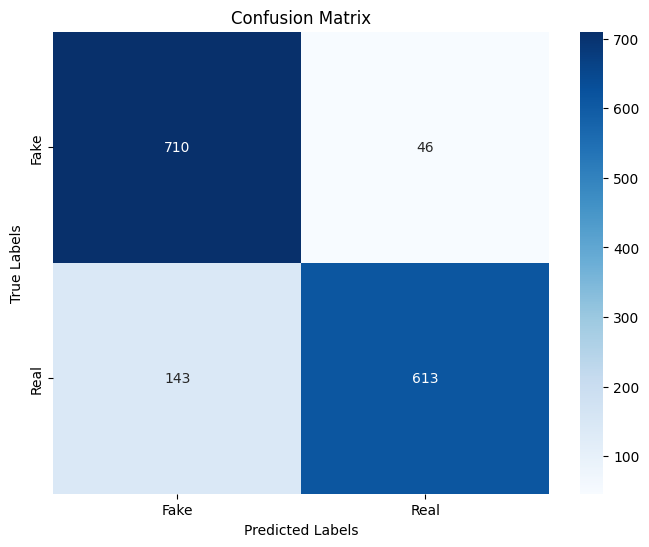

In [20]:
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define labels for the matrix
labels = ['Fake', 'Real']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


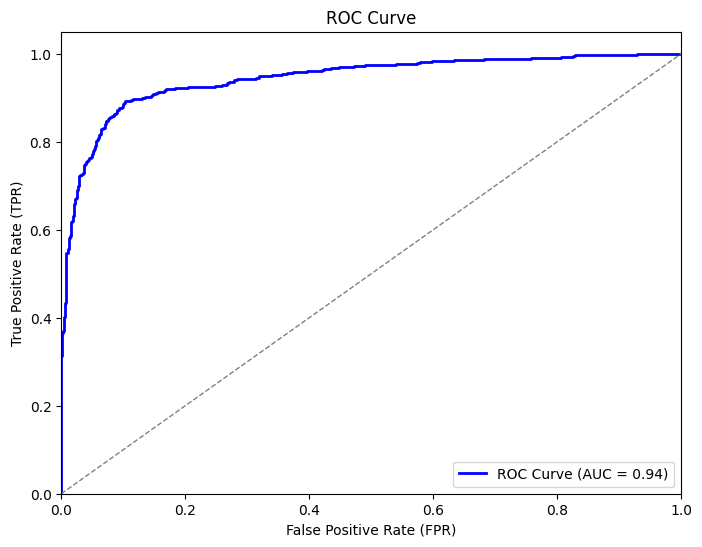

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predictions on the test dataset

predicted_probabilities = predictions.ravel()  # Flatten predictions to 1D array

# Convert labels from dataset to numpy array for evaluation
true_labels = np.array(test_labels)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [22]:
# Evaluate model performance on validation dataset
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


24/24 [==============================] - 19s 748ms/step - loss: 0.3421 - accuracy: 0.8677
Validation Loss: 0.3420562446117401
Validation Accuracy: 0.8677248954772949


In [24]:
# image path
image_path = "/content/drive/My Drive/21.png"

# Load and preprocess the image using preprocess_image function
def load_and_preprocess_image(file_path):
    # Read the image file
    img = tf.io.read_file(file_path)
    # Decode the image to RGB format
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image to match the input size for EfficientNetB4
    img = tf.image.resize(img, (380, 380))
    # Preprocess the image using EfficientNet preprocessing
    img = preprocess_input(img)
    return img

# Load and preprocess the image
input_image = load_and_preprocess_image(image_path)

# Reshape the image to a batch of 1 (since we're predicting a single image)
input_image = np.expand_dims(input_image, axis=0)

# Make prediction
prediction = model.predict(input_image)

# Display the raw predicted probabilities
print(f"Raw Prediction: {prediction}")

# Interpret the prediction
probability_fake = prediction[0][0]
probability_real = 1 - probability_fake

# Display the interpreted probabilities
print(f"Probability for 'fake' class: {probability_fake:.4f}")
print(f"Probability for 'real' class: {probability_real:.4f}")

predicted_class = 'fake' if probability_fake > 0.5 else 'real'
print(f"Predicted Class: {predicted_class}")

1/1 [==============================] - 0s 45ms/step
Raw Prediction: [[0.05713551]]
Probability for 'fake' class: 0.0571
Probability for 'real' class: 0.9429
Predicted Class: real
